**Intrusion Detection System (IDS) Analysis using PySpark**

This project focuses on analyzing network traffic data from the IDS 2018 dataset using PySpark. The goal is to perform various data preprocessing, exploratory data analysis (EDA), and machine learning to gain insights into network security.

## Installation

Installation of necessary dependencies.

In [1]:
# Install PySpark
!pip3 install pyspark

In [2]:
#import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import date_format
from pyspark.sql.functions import *
import pandas as pd
from pyspark.sql.functions import skewness
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

##Setting up SparkSession and Data Loading

In [3]:
# Linking with SparkSession
spark = SparkSession.builder.master("local[*]").appName('Intrusion Detection System (IDS) Analysis using PySpark').getOrCreate()

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load Data from Google Drive
IDS_df = spark.read.option("header", "true").csv("/content/drive/MyDrive/CN7031_IDS2018")

# Display the DataFrame
IDS_df.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+

##Data Preprocessing

In [11]:
# Replace spaces in column headers with underscores (crosstab), for better referencing and data integration
for col in IDS_df.columns:
  IDS_df = IDS_df.withColumnRenamed(col, col.replace(" ", "_"))
  IDS_df = IDS_df.withColumnRenamed(col, col.replace("/", "_"))
IDS_df.show(10)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+--------------

In [5]:
#check the data datatypes of each column to identify any inconsistency
IDS_df.printSchema()

root
 |-- Dst_Port: string (nullable = true)
 |-- Protocol: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow_Duration: string (nullable = true)
 |-- Tot_Fwd_Pkts: string (nullable = true)
 |-- Tot_Bwd_Pkts: string (nullable = true)
 |-- TotLen_Fwd_Pkts: string (nullable = true)
 |-- TotLen_Bwd_Pkts: string (nullable = true)
 |-- Fwd_Pkt_Len_Max: string (nullable = true)
 |-- Fwd_Pkt_Len_Min: string (nullable = true)
 |-- Fwd_Pkt_Len_Mean: string (nullable = true)
 |-- Fwd_Pkt_Len_Std: string (nullable = true)
 |-- Bwd_Pkt_Len_Max: string (nullable = true)
 |-- Bwd_Pkt_Len_Min: string (nullable = true)
 |-- Bwd_Pkt_Len_Mean: string (nullable = true)
 |-- Bwd_Pkt_Len_Std: string (nullable = true)
 |-- Flow_Byts/s: string (nullable = true)
 |-- Flow_Pkts/s: string (nullable = true)
 |-- Flow_IAT_Mean: string (nullable = true)
 |-- Flow_IAT_Std: string (nullable = true)
 |-- Flow_IAT_Max: string (nullable = true)
 |-- Flow_IAT_Min: string (nullable = true)
 |-- F

In [12]:
#convert string columns to float to make suitable for mathematical operations, aggregations, and statistical functions.

#Column to cast datatype to float
IDS_dfc = ['Dst_Port',
 'Protocol',
 'Flow_Duration',
 'Tot_Fwd_Pkts',
 'Tot_Bwd_Pkts',
 'TotLen_Fwd_Pkts',
 'TotLen_Bwd_Pkts',
 'Fwd_Pkt_Len_Max',
 'Fwd_Pkt_Len_Min',
 'Fwd_Pkt_Len_Mean',
 'Fwd_Pkt_Len_Std',
 'Bwd_Pkt_Len_Max',
 'Bwd_Pkt_Len_Min',
 'Bwd_Pkt_Len_Mean',
 'Bwd_Pkt_Len_Std',
 'Flow_Byts_s',
 'Flow_Pkts_s',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Tot',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Tot',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'Fwd_Header_Len',
 'Bwd_Header_Len',
 'Fwd_Pkts_s',
 'Bwd_Pkts_s',
 'Pkt_Len_Min',
 'Pkt_Len_Max',
 'Pkt_Len_Mean',
 'Pkt_Len_Std',
 'Pkt_Len_Var',
 'FIN_Flag_Cnt',
 'SYN_Flag_Cnt',
 'RST_Flag_Cnt',
 'PSH_Flag_Cnt',
 'ACK_Flag_Cnt',
 'URG_Flag_Cnt',
 'CWE_Flag_Count',
 'ECE_Flag_Cnt',
 'Down_Up_Ratio',
 'Pkt_Size_Avg',
 'Fwd_Seg_Size_Avg',
 'Bwd_Seg_Size_Avg',
 'Fwd_Byts_b_Avg',
 'Fwd_Pkts_b_Avg',
 'Fwd_Blk_Rate_Avg',
 'Bwd_Byts_b_Avg',
 'Bwd_Pkts_b_Avg',
 'Bwd_Blk_Rate_Avg',
 'Subflow_Fwd_Pkts',
 'Subflow_Fwd_Byts',
 'Subflow_Bwd_Pkts',
 'Subflow_Bwd_Byts',
 'Init_Fwd_Win_Byts',
 'Init_Bwd_Win_Byts',
 'Fwd_Act_Data_Pkts',
 'Fwd_Seg_Size_Min',
 'Active_Mean',
 'Active_Std',
 'Active_Max',
 'Active_Min',
 'Idle_Mean',
 'Idle_Std',
 'Idle_Max',
 'Idle_Min']

In [13]:
# Cast columns to float, display to view update
from pyspark.sql.functions import col
IDS_dff = (
    IDS_df.select(
        *(c for c in IDS_df.columns if c not in IDS_dfc),
        *(col(c).cast("float").alias(c) for c in IDS_dfc)
    )
)
IDS_dff.show()
IDS_dff.printSchema()

+-------------------+------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------

## Exploratory Data Analysis (EDA)

**Analyzing Attack Categories**

In [14]:
#Register the Dataframe as a SQL temporary view

IDS_dff.createOrReplaceTempView("IDSview")

+---------+-------+
| Category|  count|
+---------+-------+
|Malicious|2010110|
|   Benign|5329908|
+---------+-------+



<Axes: xlabel='Category'>

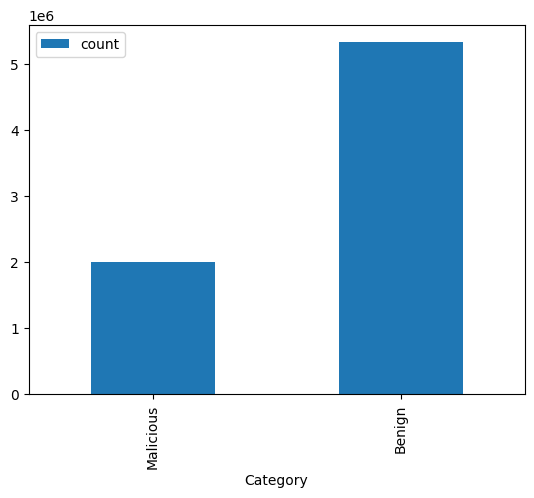

In [15]:
# Categorize the dataset into two categories: Benign and Malicious
IDSDF = spark.sql("SELECT Label, case \
                  when Label == 'Benign' then 'Benign' \
                  when Label == 'DDOS attack-HOIC' then 'Malicious' \
                  when Label == 'DoS attacks-Hulk' then 'Malicious' \
                  when Label == 'Bot' then 'Malicious' \
                  when Label == 'FTP-BruteForce' then 'Malicious' \
                  when Label == 'SSH-Bruteforce' then 'Malicious' \
                  when Label == 'DoS attacks-SlowHTTPTest' then 'Malicious' \
                  when Label == 'DoS attacks-GoldenEye' then 'Malicious' \
                  when Label == 'DoS attacks-Slowloris' then 'Malicious' \
                  when Label == 'DDOS attack-LOIC-UDP' then 'Malicious' \
                  when Label == 'Brute Force -Web' then 'Malicious' \
                  when Label == 'Brute Force -XSS' then 'Malicious' \
                  when Label == 'SQL Injection' then 'Malicious' \
       end as Category from IDSview")

# Show the total number of attempts by Category (Benign and Malicious)
IDSDF.createOrReplaceTempView("IDSDFview")
IDSDF = spark.sql("SELECT Category, count(*) as count from IDSDFview GROUP BY Category")
IDSDF.show()

#Convert the PySpark DataFrame to a Pandas DataFrame to make suitable for visualisation
IDSDF_pandas = IDSDF.toPandas()

IDSDF_pandas.plot(x='Category', y= 'count', kind= 'bar')


**Analyzing Attack Attempts by Days of the Week**

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|     Friday|3145721|
|  Wednesday|2097144|
|   Thursday|2097140|
|     Monday|      9|
|     Sunday|      3|
|   Saturday|      1|
+-----------+-------+



<Axes: xlabel='day_of_week'>

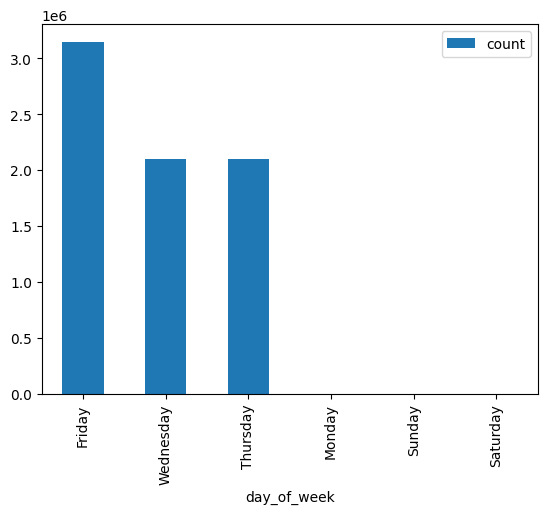

In [16]:
# Extract the day of the week from the timestamp column
df = IDS_df.withColumn("Timestamp", to_timestamp("Timestamp", "dd/MM/yyyy HH:mm:ss"))
df = df.withColumn("Timestamp_new", date_format("Timestamp", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("day_of_week", date_format("Timestamp_new", "EEEE"))

# Group by and count the dataframe by the day of the week in ascending order
df = df.groupBy("day_of_week").count().alias("count").orderBy('count', ascending=False)
df.show()

#Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()

#visualize the Dataframe
df_pandas.plot(x='day_of_week', y= 'count', kind= 'bar')

**Analytical Methods**

Correllation:

Correlation Tot_Fwd_Pkts and Pkt_Size_Avg: -0.001843827948723254
Correlation Tot_Bwd_Pkts and Pkt_Size_Avg: 0.1609942154806394


<Axes: title={'center': 'Correlations against Packet size avg'}>

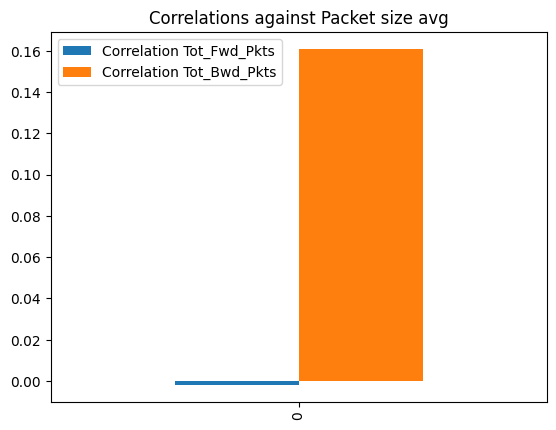

In [17]:
# Calculated the correlation between the columns Tot_Fwd_Pkts, Tot_Bwd_Pkts and Pkt_Size_Avg,
#to identify any linear associations or dependencies between variables.
corr_flowTPPkts = IDS_dff.stat.corr('Tot_Fwd_Pkts', 'Pkt_Size_Avg')
corr_flowTBPkts = IDS_dff.stat.corr('Tot_Bwd_Pkts', 'Pkt_Size_Avg')

# Print the correlation
print("Correlation Tot_Fwd_Pkts and Pkt_Size_Avg:", corr_flowTPPkts)
print("Correlation Tot_Bwd_Pkts and Pkt_Size_Avg:", corr_flowTBPkts)

corr_df = pd.DataFrame({
    'Correlation Tot_Fwd_Pkts': [corr_flowTPPkts],
    'Correlation Tot_Bwd_Pkts': [corr_flowTBPkts],
})
#visualize the dataframe
corr_df.plot(kind='bar', title='Correlations against Packet size avg', logy=False)

Skewness

Skewness of Tot_fwd_pkts: 70.24342939993414
Skewness of Tot_bwd_pkts: 229.0366048434875
Skewness of Pkts_size_avg: 3.440106024300562


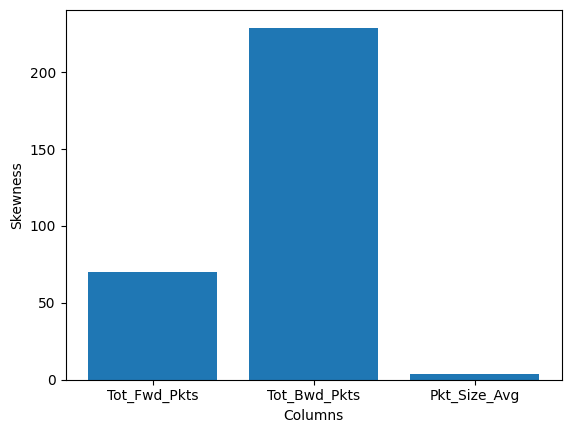

In [18]:
# Compute the skewness of the columns to gained insights into the distribution and symmetry of each feature,
#identifying any potential outliers or deviations from a normal distribution

#The [0][0] index accesses the first element in the row, which is the skewness value itself.
skew_tot_fwd_pkts = IDS_dff.select(skewness("Tot_Fwd_Pkts")).collect()[0][0]
skew_tot_bwd_pkts = IDS_dff.select(skewness("Tot_Bwd_Pkts")).collect()[0][0]
skew_pkt_size_avg = IDS_dff.select(skewness("Pkt_Size_Avg")).collect()[0][0]

print("Skewness of Tot_fwd_pkts:", skew_tot_fwd_pkts)
print("Skewness of Tot_bwd_pkts:", skew_tot_bwd_pkts)
print("Skewness of Pkts_size_avg:", skew_pkt_size_avg)

# Create a bar plot to compare the skewness of the columns
plt.bar([1, 2, 3], [skew_tot_fwd_pkts, skew_tot_bwd_pkts, skew_pkt_size_avg])
plt.xticks([1, 2, 3], ["Tot_Fwd_Pkts", "Tot_Bwd_Pkts", "Pkt_Size_Avg"])
plt.xlabel("Columns")
plt.ylabel("Skewness")

# Show the plot
plt.show()

Advanced Descriptive Analysis

In [19]:
#Further explored "Tot_Bwd_Pkts" and "Pkt_Size_Avg" columns uncover patterns, trends, and potential anomalies.

# Select the "Tot_Bwd_Pkts" and "Pkt_Size_Avg" columns
df = IDS_dff.select("Tot_Bwd_Pkts", "Pkt_Size_Avg")

# Compute advanced descriptive statistics
df = df.describe()

# Show the results
df.show()

+-------+------------------+-----------------+
|summary|      Tot_Bwd_Pkts|     Pkt_Size_Avg|
+-------+------------------+-----------------+
|  count|           7340018|          7340018|
|   mean|5.9616829277530385|84.30607925017941|
| stddev| 171.3252494015615|108.9211684458409|
|    min|               0.0|              0.0|
|    max|          123118.0|        3328.2988|
+-------+------------------+-----------------+



## Machine Learning

Mean Squared Error:  1.7228032655848151


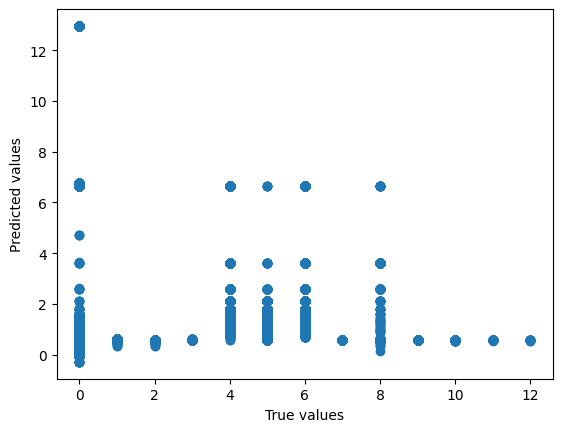

In [20]:
# Create a StringIndexer object to convert string value in "Label" to numeric indices in "Label_index"
indexer = StringIndexer(inputCol="Label", outputCol="Label_index")

# Fit the indexer to the data and transform the DataFrame
indexed_data = indexer.fit(IDS_dff).transform(IDS_dff)

# Combine the two columns into a single vector column to be usable by the ML model
vector_assembler = VectorAssembler(inputCols=["Fwd_Pkts_s", "Bwd_Pkts_s"],
                                    outputCol="features")

vector_data = vector_assembler.transform(indexed_data)

# Split the data into training and test sets
training_data, test_data = vector_data.randomSplit([0.7, 0.3])

# Create a LinearRegression object and fit it to the training data
lr = LinearRegression(featuresCol="features", labelCol="Label_index")
model = lr.fit(training_data)

# Use the model to make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol="Label_index", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error: ", mse)


# Convert the DataFrame to a Pandas DataFrame usable by matplotlib library to visualize the values
predictions_pd = predictions.select(["Label_index", "prediction"]).toPandas()


# Create a scatter plot of the predicted vs. true values
plt.scatter(predictions_pd["Label_index"], predictions_pd["prediction"])
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()
